In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import joblib

In [2]:
open('accent-mfcc-data-1.csv')

<_io.TextIOWrapper name='accent-mfcc-data-1.csv' mode='r' encoding='cp936'>

In [3]:
acc = pd.read_csv('accent-mfcc-data-1.csv')
print(acc.shape)
acc.head(2)

(329, 13)


,language,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
0,ES,7.071476,-6.512900,7.65080,11.150783,-7.657312,12.484021,-11.709772,3.426596,1.462715,-2.812753,0.866538,-5.244274
1,ES,10.982967,-5.157445,3.95206,11.529381,-7.638047,12.136098,-12.036247,3.491943,0.595441,-4.508811,2.332147,-6.221857


In [4]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
print_unique(acc)

language 
 ['ES' 'FR' 'GE' 'IT' 'UK' 'US'] 

X1 
 [-6.06783115 -4.83524226 -4.22235861 -4.03682126 -3.99585223 -3.76331338
 -3.7233767  -3.42846439 -3.39057677 -3.2505066  -3.17716703 -2.89940273
 -2.88082269 -2.86391    -2.76571765 -2.59575298 -2.34812251 -2.33969484
 -2.2858864  -2.11273315 -2.09400127 -2.02046103 -1.89239592 -1.86745928
 -1.79862496 -1.68172948 -1.59182531 -1.52918762 -1.27203756 -1.27066317
 -1.11495928 -1.0767638  -0.79162084 -0.73479663 -0.71874375 -0.6046829
 -0.5252725  -0.45848312 -0.41964308 -0.41503686 -0.26773795 -0.21749779
 -0.13087789  0.0408546   0.04716369  0.15607571  0.15977883  0.25004505
  0.26592603  0.29961639  0.45884741  0.46183851  0.50481337  0.54757493
  0.56381219  0.69645264  0.70040596  0.82030155  0.90042641  0.90684605
  0.91113322  0.93994295  0.94236034  0.98751379  1.09886433  1.16759207
  1.23213085  1.38589052  1.46784241  1.51589664  1.54014906  1.5874817
  1.64926323  1.68417764  1.69945287  1.80460566  1.87259413  1.87614589
  1

In [5]:
def get_snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

In [6]:
snapshot = get_snapshot(acc)
snapshot

,n_unique,dtype,n_missing,pct_missing
language,6,object,0,0.0
X1,329,float64,0,0.0
X2,329,float64,0,0.0
X3,329,float64,0,0.0
X4,329,float64,0,0.0
X5,329,float64,0,0.0
X6,329,float64,0,0.0
X7,329,float64,0,0.0
X8,329,float64,0,0.0
X9,329,float64,0,0.0


In [7]:
features = acc.columns.drop('language')

In [8]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    df[col].value_counts().plot.bar(color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()

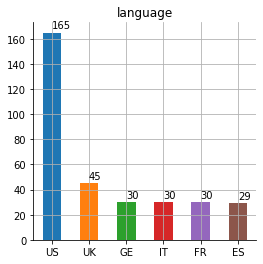

In [9]:
plot_single_categorical(acc, 'language')

In [12]:
acc_dummi = pd.get_dummies(acc, columns = ['language'], dtype = int).join(acc['language'])

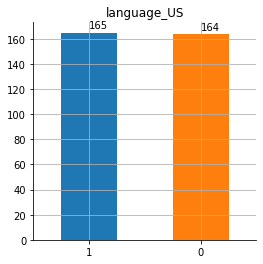

In [13]:
plot_single_categorical(acc_dummi, 'language_US')

In [14]:
def feat_significance(X, y, n_feat_data_type, features):
    mi_df = pd.DataFrame(mutual_info_classif(X, y, random_state = 42), index = X.columns, columns = ['score'])
    mi_df = mi_df.sort_values(by = 'score', ascending = False)
    
    def color_cell(s):    
        background = []
        for i in range(len(s.index)):
            if s.index[i] in features:
                background.append('background-color: yellow')
            else:
                background.append('')
        return background
    
    if n_feat_data_type == 1:
        return mi_df
    else:
        return mi_df.style.apply(color_cell, axis = 0)

In [15]:
feat_score = feat_significance(acc_dummi[features], acc_dummi['language_US'], 1, '')
feat_score

,score
X6,0.132768
X9,0.113617
X10,0.098690
X11,0.097384
X7,0.094245
X8,0.085021
X5,0.082327
X12,0.053769
X2,0.034331
X1,0.029622


In [16]:
def get_mean_std(df):
    mean_col = pd.DataFrame(df.mean(), columns = ['mean'])
    std_col = pd.DataFrame(df.std(), columns = ['std'])
    mean_plus_std = mean_col.join(std_col)
    return mean_plus_std

In [18]:
get_mean_std(acc_dummi[features])

,mean,std
X1,5.645227,5.105302
X2,-4.270814,3.514350
X3,2.635319,3.635323
X4,7.200207,4.310095
X5,-5.648733,4.596180
X6,9.810236,3.624654
X7,-9.408053,2.484117
X8,5.117328,2.650608
X9,-1.229432,3.634849
X10,-2.362288,5.042034


In [19]:
lr = LogisticRegression(random_state = 42)
knn = KNeighborsClassifier()
svc = SVC(random_state = 42)
tree = DecisionTreeClassifier(max_features = 'auto', random_state = 42)
alg_dict = {lr: 'lr', svc: 'svc', knn: 'knn', tree: 'tree'}

In [20]:
def num_feat_perform(algorithm, feat_ordered, X_ordered, y, metric):
    scores = []
    for i in range(1, len(feat_ordered)+1):
        pred_data = X_ordered.iloc[:, 0:i]
        score = mean(cross_val_score(algorithm, pred_data, y, scoring = metric, cv = 5))
        scores.append(score)

    n_features = len(feat_ordered)
    plt.plot(np.arange(n_features), scores, marker = 'x')
    plt.xticks(np.arange(n_features), np.arange(1, n_features + 1))
    for i in range(n_features):
        plt.text(i, scores[i], s = round(scores[i], 2))
    plt.grid()
    plt.xlabel('no. of features')
    plt.ylabel('score')
    
def num_feat_multi_alg(alg_dict, feat_ordered, X_ordered, y, metric):
    n_algorithm = len(alg_dict)
    algorithms = list(alg_dict.keys())
    alg_names = list(alg_dict.values())
    if n_algorithm <= 2:
        nrows = 1
        ncols = n_algorithm
        fig = plt.figure(figsize = (ncols * 6, 4))
    else:
        nrows = math.ceil(n_algorithm / 2)
        ncols = 2
        fig = plt.figure(figsize = (12, nrows * 4))

    for n in range(n_algorithm):
        ax = fig.add_subplot(nrows, ncols, n + 1)
        ax = num_feat_perform(algorithms[n], feat_ordered, X_ordered, y, metric)
        plt.title(f"'{alg_names[n]}' performance by '{metric}'")
        
    plt.tight_layout()
    plt.show()

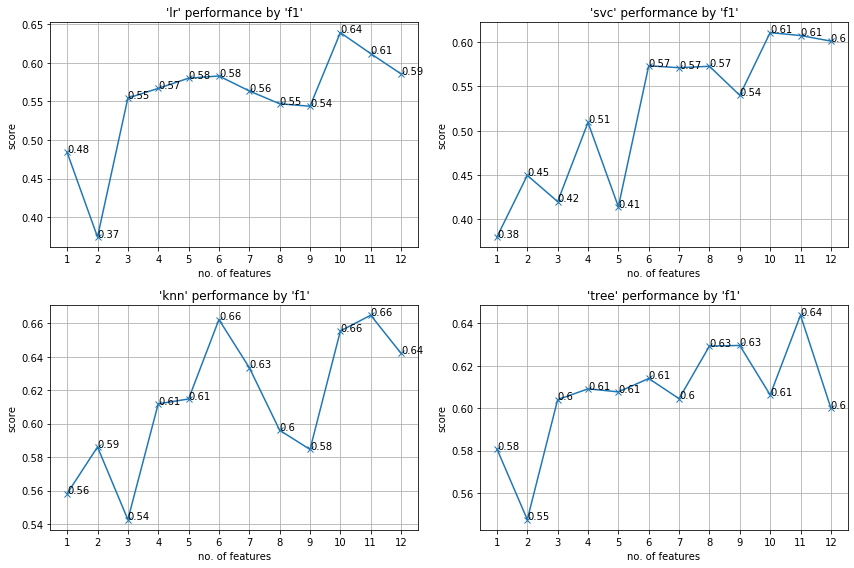

In [21]:
num_feat_multi_alg(alg_dict, feat_score.index, acc_dummi[feat_score.index], acc_dummi['language_US'], 'f1')

In [24]:
feat_knn = feat_score.index[0:6]
feat_knn

Index(['X6', 'X9', 'X10', 'X11', 'X7', 'X8'], dtype='object')

In [26]:
def plot_learning_curve(train_scores, test_scores, train_sizes):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
def two_metric_graph(algorithm, X, y):
    train_sizes = np.linspace(start = 20, stop = X.shape[0] * 0.8, num = 6, dtype = int)
    fig = plt.figure(figsize = (10, 4))

    for i, metric in enumerate(['f1', 'balanced_accuracy']):
        train_sizes_abs, train_scores, test_scores = learning_curve(algorithm, X, y, train_sizes = train_sizes, 
                                                                    scoring = metric, cv = 5, shuffle = True, 
                                                                    random_state = 42)
        ax = fig.add_subplot(1, 2, i + 1)
        ax = plot_learning_curve(train_scores, test_scores, train_sizes)
        plt.title(f"'performance by '{metric}'")

    plt.tight_layout()
    plt.show()

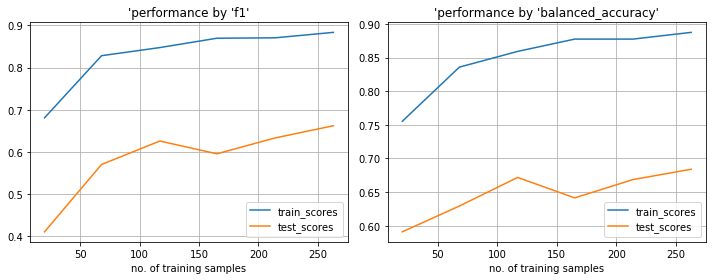

In [27]:
two_metric_graph(knn, acc_dummi[feat_knn], acc_dummi['language_US'])

In [28]:
knn.fit(acc_dummi[feat_knn], acc_dummi['language_US'])
joblib.dump(knn, 'knn.joblib')

['knn.joblib']